In [ ]:
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 5.0 MB/s 
     |████████████████████████████████| 71 kB 4.0 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp38-cp38-linux_x86_64.whl size=2783600 sha256=9c8dc0bbc8568c70a56baad8886f7fe4920b2aa2b66f7f1b20d970c77328a007
  Stored in directory: /root/.cache/pip/wheels/48/b3/22/31f07cfd7b182ea3703151b7e5a7d6447e3e1ac6aa5c529413
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=7bc75f81b6489e143ebe507f97bc594242375c0015bcecfac370dacf7151d469
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz


In [ ]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

In [ ]:
class TargetPrior():
  
  def __init__(self, kernel="sq_exp", d_cardinal=1000):
    self.d_cardinal = d_cardinal
    self.X = np.linspace(0, 1, self.d_cardinal)[:, None]

    self.mu = np.zeros(self.d_cardinal)

    if kernel == "sq_exp":
      self.k = GPy.kern.RBF(1)
    elif kernel == "matern":
      self.k = GPy.kern.Matern32(1)
    else:
      raise ValueError("Invalid kernel")
    self.k.lengthscale = 0.2

    self.C = self.k.K(self.X, self.X)

    self.Y = np.random.multivariate_normal(self.mu, self.C, 1)[0]
  
  def sample(self, x):
    return self.Y[int(np.unique(x))]
    #return np.sin(x)
  
  def sample_noisy(self, x):
    return self.sample(x) + np.random.normal(0, 0)
  
  def best_action(self):
    return np.argmax(self.Y)
  
  def best_reward(self):

    best_action_idx = self.best_action()
    return self.sample_noisy(best_action_idx)

In [ ]:
class GPUCB():

  def __init__(self, target, rounds=50, acquisition="GPUCB", kernel="sq_exp", delta=0.1, d_cardinal=1000):

    self.target = target
    self.d_cardinal = d_cardinal
    self.interval = np.linspace(0, 1, self.d_cardinal)[:, None]

    self.X = np.zeros(rounds)[:, None]
    self.Y = np.zeros(rounds)[:, None]

    self.regrets = np.zeros(rounds)

    self.beta = None
    self.delta = delta

    if kernel == "sq_exp":
      self.kernel = GPy.kern.RBF(1)
    elif kernel == "matern":
      self.kernel = GPy.kern.Matern32(1)
    else:
      raise ValueError("Invalid kernel")

    self.kernel.lengthscale = 0.2
    self.kernel.fix()
    
    self.mu = np.zeros(self.interval.size)
    self.sigma = np.ones(self.interval.size)/2

    self.round = 1
    self.rounds = rounds

    self.acquisition = None

    if acquisition == "GPUCB":
      self.acquisition = self.GPUCB_next_point
    elif acquisition == "mean":
      self.acquisition = self.mean_next_point
    elif acquisition == "var":
      self.acquisition = self.var_next_point
    else:
      raise ValueError("Invalid acquisition function")
      

  def GPUCB_next_point(self):

    # Choose optimal exploration parameter (Theorem 1)
    self.beta = 2*np.log(self.d_cardinal*(self.round**2)*(np.pi**2)/(6*self.delta))
    
    # Choose an action according to the exploration parameter
    action_idx = np.argmax(self.mu + np.sqrt(self.beta)*self.sigma)
    action = self.interval[action_idx]

    return action, action_idx


  def mean_next_point(self):
    
    # Choose an action according to the mean
    action_idx = np.argmax(self.mu)
    action = self.interval[action_idx]

    return action, action_idx


  def var_next_point(self):

    # Choose an action according to the std
    action_idx = np.argmax(self.sigma)
    action = self.interval[action_idx]

    return action, action_idx

  
  def update(self, plotting=False):

    # Get optimal next action according to the acquisition function
    action, action_idx = self.acquisition()

    # Get noisy feedback
    reward = self.target.sample_noisy(action_idx)

    # Store for Bayesian update
    self.X[self.round-1] = action
    self.Y[self.round-1] = reward

    # GP Regression
    gp_model = GPy.models.GPRegression(self.X[:self.round], self.Y[:self.round], self.kernel)
    gp_model.optimize()

    # Update parameters
    self.mu, var = gp_model.predict(self.interval)
    self.sigma = np.sqrt(var)

    # Compute regret for this round
    best_reward = self.target.best_reward()
    regret = best_reward - reward

    # Store regret
    self.regrets[self.round-1] = regret

    if plotting:
      self.plot(self.X[:self.round], self.Y[:self.round])

    # Proceed to the next round
    self.round += 1
  

  def train(self, update_plot=False, train_plot=False, no_print=True):

    for i in tqdm(range(self.rounds), disable=no_print):
      self.update(update_plot)
    
    if train_plot:
      self.plot(self.X, self.Y)

  
  def plot(self, X, Y):

    plt.figure()
    plt.plot(self.target.X, self.target.Y)
    plt.plot(X, Y, "ro")
    plt.show()


In [ ]:
def avg_regret(regret):
  cumulative = np.cumsum(regret)
  avg_regret = np.divide(cumulative, np.linspace(1, len(cumulative), len(cumulative)))
  return avg_regret

In [ ]:
def min_regret(regret):
  return np.minimum.accumulate(regret)

In [ ]:
def reproducibility(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
rounds = 100
experiments = 30
kernel = "matern"

reproducibility(0)

acquisitions = ["GPUCB", "mean", "var"]
avg_regrets = np.zeros((len(acquisitions), rounds))
min_regrets = np.zeros((len(acquisitions), rounds))

for i in range(3):
  acquisition = acquisitions[i]

  for j in tqdm(range(experiments), disable=False):
    target = TargetPrior(kernel=kernel)
    gp_agent = GPUCB(target, rounds=rounds, kernel=kernel, acquisition=acquisition)
    gp_agent.train()
    regret = gp_agent.regrets
    avg_regrets[i, :] += avg_regret(regret)
    min_regrets[i, :] += min_regret(regret)

  avg_regrets[i, :] /= experiments
  min_regrets[i, :] /= experiments

100%|██████████| 30/30 [03:41<00:00,  7.39s/it]


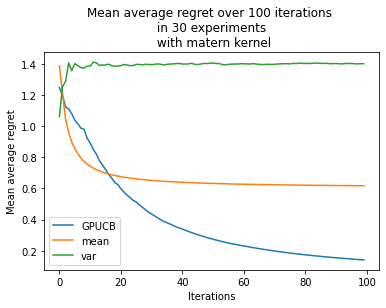

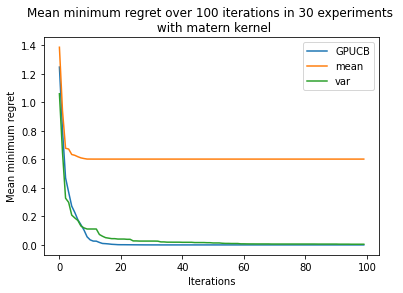

In [ ]:
plt.figure()
plt.title(f"Mean average regret over {rounds} iterations \n in {experiments} experiments \n with {kernel} kernel")
plt.xlabel("Iterations")
plt.ylabel("Mean average regret")
plt.plot(np.arange(rounds), avg_regrets[0, :], label="GPUCB")
plt.plot(np.arange(rounds), avg_regrets[1, :], label="mean")
plt.plot(np.arange(rounds), avg_regrets[2, :], label="var")
plt.legend()
plt.show()

plt.figure()
plt.title(f"Mean minimum regret over {rounds} iterations in {experiments} experiments \n with {kernel} kernel")
plt.xlabel("Iterations")
plt.ylabel("Mean minimum regret")
plt.plot(np.arange(rounds), min_regrets[0, :], label="GPUCB")
plt.plot(np.arange(rounds), min_regrets[1, :], label="mean")
plt.plot(np.arange(rounds), min_regrets[2, :], label="var")
plt.legend()
plt.show()

100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


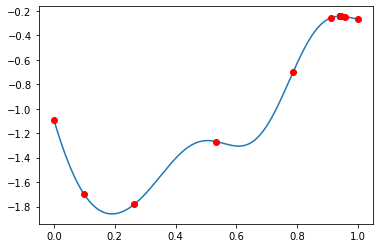

In [ ]:
gp_agent.train()